Final Project

Name: Jason Wang

USC ID: 5363148736


In [1]:
import pandas as pd
import numpy as np
import os
import re
import keras
from collections import Counter
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
import matplotlib.pyplot as plt


In [2]:
# preprocessing
pos_training = []
neg_training = []
pos_test = []
neg_test = []
file_check = []
words = []

pos_folder = os.listdir('pos')
neg_folder = os.listdir('neg')

for i, file in enumerate(pos_folder):
    if i <700: #0-699 for training, csvs are already sorted
        file_check.append(file)
        with open (os.path.join('pos',file), 'r') as f:
            text = f.read()
            text = re.sub(r'\d', '', text)  # removing puncutation https://stackoverflow.com/questions/18429143/strip-punctuation-with-regex-python
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'[_]', '', text)
            word = text.split()
            words.extend(word)
            pos_training.append((text,1)) # binary encoding for sentiments
    elif i > 700:
        with open (os.path.join('pos',file), 'r') as f:
            text = f.read()
            text = re.sub(r'\d', '', text) 
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'[_]', ' ', text)
            word = text.split()
            words.extend(word)
            pos_test.append((text,1))

for i, file in enumerate(neg_folder):
    if i < 700:
        with open (os.path.join('neg',file), 'r') as f:
            text = f.read()
            text = re.sub(r'\d', '', text)  
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'[_]', ' ', text)
            word = text.split()
            words.extend(word)
            neg_training.append((text,-1))
    elif i > 700:
        with open (os.path.join('neg',file), 'r') as f:
            text = f.read()
            text = re.sub(r'\d', '', text)  
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'[_]', ' ', text)
            word = text.split()
            words.extend(word)
            neg_test.append((text,-1))

# print(file_check)
full_dataset = pos_training+ neg_training + pos_test + neg_test

pos_training_df = pd.DataFrame(pos_training, columns=['text', 'label'])
neg_training_df = pd.DataFrame(neg_training, columns=['text', 'label'])
pos_test_df = pd.DataFrame(pos_test, columns=['text', 'label'])
neg_test_df = pd.DataFrame(neg_test, columns=['text', 'label'])

full_training_df = pd.concat([pos_training_df,neg_training_df])
full_test_df = pd.concat([pos_test_df,neg_test_df])

full_data_df = pd.DataFrame(full_dataset, columns=['text', 'label'])

print(full_data_df.head())


                                                text  label
0  films adapted from comic books have had plenty...      1
1  every now and then a movie comes along from a ...      1
2  youve got mail works alot better than it deser...      1
3    jaws  is a rare film that grabs your attenti...      1
4  moviemaking is a lot like being the general ma...      1


In [3]:
average = len(words)/1998
count = Counter(words) 
lengths = []
i = 0
for j,row in enumerate(full_data_df['text']):
    texts = row.split()
    length = len(texts)
    lengths.append(length)
    i += np.sqrt((length - average)**2)

sd = np.sqrt(i/1998)

print(f'Number of total words: {len(words)}') 
print(f'Number of Unique words: {len(count)}')
print(f'Average Review Length: {average}')
print(f'SD Review Length: {sd}')


Number of total words: 1286868
Number of Unique words: 46727
Average Review Length: 644.0780780780781
SD Review Length: 14.567780002739045


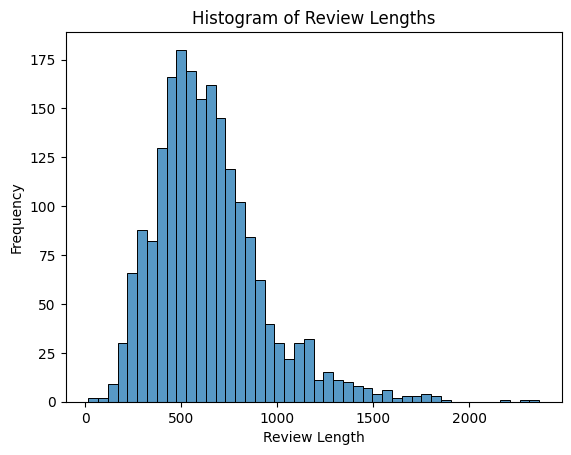

In [4]:
sns.histplot(data = full_data_df, x = lengths)
plt.title('Histogram of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [5]:
tokenizer = Tokenizer()

all_data_tokenize = full_data_df['text'].tolist()
training_tokenize = full_training_df['text'].tolist()
test_tokenize = full_test_df['text'].tolist()

#https://stackoverflow.com/questions/54891464/is-it-better-to-keras-fit-to-text-on-the-entire-x-data-or-just-the-train-data
# read it is better to only fit on training data to prevent data leakage/ bias in model

tokenizer.fit_on_texts(training_tokenize)

train_seq = tokenizer.texts_to_sequences(training_tokenize)
test_seq = tokenizer.texts_to_sequences(test_tokenize)
all_seq = tokenizer.texts_to_sequences(all_data_tokenize)

print(len(train_seq))

1400


In [6]:
sequence_lengths = []
for seq in all_seq:
    sequence_lengths.append(len(seq))

L = np.percentile(sequence_lengths, 70)
L

734.0

In [7]:
#https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results did some research and it seems that pre padding leads to more accuracy / less noise
padded_training_seq = pad_sequences(train_seq, maxlen = int(np.floor(L)), padding = 'pre', truncating= 'pre' )
padded_training_df = pd.DataFrame(padded_training_seq)

padded_test_seq = pad_sequences(test_seq, maxlen = int(np.floor(L)), padding = 'pre', truncating= 'pre' )
padded_test_df = pd.DataFrame(padded_test_seq)

padded_training_seq



array([[    0,     0,     0, ...,     3,  1072,  1487],
       [    0,     0,     0, ...,    10,     2,  1950],
       [    0,     0,     0, ...,     1,   610,  7304],
       ...,
       [    0,     0,     0, ..., 14164,    30,  2421],
       [    0,     0,     0, ...,   230,     7,  6634],
       [    0,     0,     0, ...,     9,    25,   208]])

In [8]:
# Word Embeddings
# https://keras.io/api/layers/core_layers/embedding/ below is taken from keras.io
training_top_5000 = np.where(padded_training_seq > 5000, 0, padded_training_seq)

embed = Embedding(5001, 32)
flatten = Flatten()

training_output = embed(training_top_5000)
training_output_flat = flatten(training_output)

training_output = training_output.numpy()
torch_training_output = torch.tensor(training_output)

training_output_flat = training_output_flat.numpy()
torch_training_output_flat = torch.tensor(training_output_flat)

print(training_output.shape)
print(training_output_flat.shape)


(1400, 734, 32)
(1400, 23488)


In [9]:
# Train a MLP with three (dense) hidden layers each of which has 50 ReLUs
# and one output layer with a single sigmoid neuron. Use a dropout rate of
# 20% for the first layer and 50% for the other layers. Use ADAM optimizer
# and binary cross entropy loss (which is equivalent to having a softmax in the
# output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.

#https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/
# used the above as reference to building this mlp

mlp = nn.Sequential()
mlp.add_module('dense1', nn.Linear(23488, 50))
mlp.add_module('act1', nn.ReLU())
mlp.add_module('dropout1', nn.Dropout(p=0.2))
mlp.add_module('dense2', nn.Linear(50,50))
mlp.add_module('act2', nn.ReLU())
mlp.add_module('droupout2', nn.Dropout(p=0.5))
mlp.add_module('dense3', nn.Linear(50,50))
mlp.add_module('act3', nn.ReLU())
mlp.add_module('droupout3', nn.Dropout(p=0.5))
mlp.add_module("output", nn.Linear(50, 1))
mlp.add_module("outact", nn.Sigmoid())


print(mlp)

Sequential(
  (dense1): Linear(in_features=23488, out_features=50, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=50, out_features=50, bias=True)
  (act2): ReLU()
  (droupout2): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=50, out_features=50, bias=True)
  (act3): ReLU()
  (droupout3): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (outact): Sigmoid()
)


In [10]:
training_labels = full_training_df['label']
training_labels = training_labels.to_numpy()
training_labels = torch.tensor(training_labels)
training_labels = (training_labels+1)//2


# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

training_tensor_dataset = TensorDataset(torch_training_output_flat, training_labels)
train_dataloader = DataLoader(training_tensor_dataset, batch_size=10, shuffle = True)

loss_type = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters())

for i, epoch in enumerate(range(2)):
    mlp.train()
    training_correct = 0
    training_total = 0
    
    # This part below was helped written with chatgpt, i was getting errors with the labels and how to corrrectly use dataloader with training the model.

    for inputs, targets in train_dataloader:
        #forward prop
        outputs = mlp(inputs)
        targets = targets.float()
        loss = loss_type(outputs.squeeze(), targets)
        #backward prop
        optimizer.zero_grad()
        loss.backward()
        #grad descent
        optimizer.step()

        training_loss = loss.item()
        predict = (outputs.squeeze() > 0.5)
        training_correct += (predict== targets).sum().item()
        training_total += targets.size(0)

    print(f'Epoch {i+1} Loss is: {training_loss}')
    training_accuracy = training_correct / training_total
    print(f'Trainining Accuracy: {training_accuracy}')


Epoch 1 Loss is: 0.677640974521637
Trainining Accuracy: 0.4857142857142857
Epoch 2 Loss is: 0.5845378637313843
Trainining Accuracy: 0.5578571428571428


In [11]:
testing_top_5000 = np.where(padded_test_seq > 5000, 0, padded_test_seq)
testing_output = embed(testing_top_5000)
testing_output_flat = flatten(testing_output)

testing_output = testing_output.numpy()
torch_testing_output = torch.tensor(testing_output)

testing_output_flat = testing_output_flat.numpy()
torch_testing_output_flat = torch.tensor(testing_output_flat)

testing_labels = full_test_df['label']
testing_labels = testing_labels.to_numpy()
testing_labels = torch.tensor(testing_labels)
testing_labels = (testing_labels+1)//2

testing_tensor_dataset = TensorDataset(torch_testing_output_flat, testing_labels)
test_dataloader = DataLoader(testing_tensor_dataset, batch_size=10)

mlp.eval()
# https://datascience.stackexchange.com/questions/32651/what-is-the-use-of-torch-no-grad-in-pytorch
# disabling gradient calculation is useful for inference, reduces memory consumption for computations
with torch.no_grad():
    test_correct = 0
    test_total = 0
    for inputs, targets in test_dataloader:
        outputs = mlp(inputs)
        predict = (outputs.squeeze() > 0.5)
        test_correct += (predict== targets).sum().item()
        test_total += targets.size(0)

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.5418060200668896


In [12]:
# One Dimensional CNN
# After the embedding layer, insert a Conv1D layer. This convolutional layer
# has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded
# word representations 3 vector elements of the word embedding at a time. The
# convolutional layer is followed by a 1D max pooling layer with a length and
# stride of 2 that halves the size of the feature maps from the convolutional
# layer. The rest of the network is the same as the neural network above

training_top_5000_cnn = np.where(padded_training_seq > 5000, 0, padded_training_seq)

embed = Embedding(5001, 32)
C1D = Conv1D(32, kernel_size = 3)
MaxPooling = MaxPooling1D(pool_size =2, strides = 2)
flatten = Flatten()

training_output_cnn = embed(training_top_5000_cnn)
training_output_C1D = C1D(training_output_cnn)
training_output_Maxpool = MaxPooling(training_output_C1D)
training_output_cnn_flat = flatten(training_output_Maxpool)


In [13]:
cnn = nn.Sequential()
cnn.add_module('dense1', nn.Linear(11712, 50))
cnn.add_module('act1', nn.ReLU())
cnn.add_module('dropout1', nn.Dropout(p=0.2))
cnn.add_module('dense2', nn.Linear(50,50))
cnn.add_module('act2', nn.ReLU())
cnn.add_module('droupout2', nn.Dropout(p=0.5))
cnn.add_module('dense3', nn.Linear(50,50))
cnn.add_module('act3', nn.ReLU())
cnn.add_module('droupout3', nn.Dropout(p=0.5))
cnn.add_module("output", nn.Linear(50, 1))
cnn.add_module("outact", nn.Sigmoid())

print(cnn)

Sequential(
  (dense1): Linear(in_features=11712, out_features=50, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=50, out_features=50, bias=True)
  (act2): ReLU()
  (droupout2): Dropout(p=0.5, inplace=False)
  (dense3): Linear(in_features=50, out_features=50, bias=True)
  (act3): ReLU()
  (droupout3): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (outact): Sigmoid()
)


In [14]:
training_output_cnn_flat = training_output_cnn_flat.numpy()
cnn_training_tensor = torch.tensor(training_output_cnn_flat)

cnn_training_tensor_dataset = TensorDataset(cnn_training_tensor, training_labels)
cnn_train_dataloader = DataLoader(cnn_training_tensor_dataset, batch_size=10, shuffle = True)

loss_type = nn.BCELoss()
optimizer = torch.optim.Adam(cnn.parameters())

for i, epoch in enumerate(range(2)):
    cnn.train()
    cnn_training_correct = 0
    cnn_training_total = 0
    
    for inputs, targets in cnn_train_dataloader:
        #forward prop
        cnn_outputs = cnn(inputs)
        cnn_targets = targets.float()
        cnn_loss = loss_type(cnn_outputs.squeeze(), cnn_targets)
        #backward prop
        optimizer.zero_grad()
        cnn_loss.backward()
        #grad descent
        optimizer.step()
        
        cnn_predict = (cnn_outputs.squeeze() > 0.5)
        cnn_training_correct += (cnn_predict== targets).sum().item()
        cnn_training_total += targets.size(0)

    print(f'Epoch {i+1} Loss is: {cnn_loss.item()}')
    cnn_training_accuracy = cnn_training_correct / cnn_training_total
    print(f'CNN Trainining Accuracy: {cnn_training_accuracy}')


Epoch 1 Loss is: 0.7236382961273193
CNN Trainining Accuracy: 0.5135714285714286
Epoch 2 Loss is: 0.7028557062149048
CNN Trainining Accuracy: 0.525


In [15]:
testing_top_5000_cnn = np.where(padded_test_seq > 5000, 0, padded_test_seq)

testing_output_cnn = embed(testing_top_5000_cnn)
testing_output_C1D = C1D(testing_output_cnn)
testing_output_Maxpool = MaxPooling(testing_output_C1D)
testing_output_cnn_flat = flatten(testing_output_Maxpool)

testing_output_cnn_flat = testing_output_cnn_flat.numpy()
cnn_testing_tensor = torch.tensor(testing_output_cnn_flat)

cnn_testing_tensor_dataset = TensorDataset(cnn_testing_tensor, testing_labels)
cnn_test_dataloader = DataLoader(cnn_testing_tensor_dataset, batch_size=10)

cnn.eval()
with torch.no_grad():
    cnn_test_correct = 0
    cnn_test_total = 0
    for inputs, targets in cnn_test_dataloader:
        cnn_outputs = cnn(inputs)
        cnn_predict = (cnn_outputs.squeeze() > 0.5)
        cnn_test_correct += (cnn_predict== targets).sum().item()
        cnn_test_total += targets.size(0)

cnn_test_accuracy = cnn_test_correct / cnn_test_total
print(f'CNN Test Accuracy: {cnn_test_accuracy}')

CNN Test Accuracy: 0.5384615384615384


In [16]:
#LSTM 
# Each word is represented to LSTM as a vector of 32 elements and the LSTM
# is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both
# LSTM and the dense layer. Train the model using 10-50 epochs and batch
# size of 10.

# Switched to keras LSTM model because my pytorch LSTM model was not converging no matter what I tried.
lstm_training_top_5000 = np.where(padded_training_seq > 5000, 0, padded_training_seq)
training_labels = full_training_df['label']
training_labels = training_labels.to_numpy()
training_labels = (training_labels+1)//2

# https://keras.io/api/layers/recurrent_layers/lstm/ 
# I did reference ChatGPT for the below to ensure I was applying every step correctly
model_lstm = keras.Sequential()
model_lstm.add(Embedding(5001, 32))
model_lstm.add(LSTM(units=32, return_sequences= True, dropout= 0.2, recurrent_dropout= 0.2)) 
model_lstm.add(LSTM(units=32, return_sequences= True, dropout= 0.2, recurrent_dropout= 0.2)) 
model_lstm.add(LSTM(units=32, return_sequences= True, dropout= 0.2, recurrent_dropout= 0.2)) 
model_lstm.add(LSTM(units=32, return_sequences= False, dropout= 0.2, recurrent_dropout= 0.2)) # 4th stacked layer that takes outputs from three previous and outputs to the hidden layer shown in the project chart
model_lstm.add(Dense(256))
model_lstm.add(Activation('relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.add(Activation('sigmoid'))

model_lstm.compile(optimizer= 'adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_lstm.fit(lstm_training_top_5000, training_labels, epochs= 10, batch_size= 10)


Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 47s 307ms/step - accuracy: 0.4879 - loss: 0.6937
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 293ms/step - accuracy: 0.6327 - loss: 0.6416
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.8736 - loss: 0.3184
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 277ms/step - accuracy: 0.9436 - loss: 0.2072
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 38s 271ms/step - accuracy: 0.9617 - loss: 0.1234
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 38s 272ms/step - accuracy: 0.9781 - loss: 0.0803
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - accuracy: 0.9777 - loss: 0.0670
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 38s 272ms/step - accuracy: 0.9857 - loss: 0.0519
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - accuracy: 0.9947 - loss: 0.0218
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - accuracy: 0.9954 - loss: 0.0214


In [17]:
lstm_testing_top_5000 = np.where(padded_test_seq > 5000, 0, padded_test_seq)
testing_labels = full_test_df['label']
testing_labels = testing_labels.to_numpy()
testing_labels = (testing_labels+1)//2

loss, accuracy = model_lstm.evaluate(lstm_testing_top_5000,testing_labels)
print(f'Test accuracy: {accuracy}')



19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.6497 - loss: 1.7369
Test accuracy: 0.6906354427337646
